<a href="https://colab.research.google.com/github/1000century/InterviewAnswer/blob/main/v4_oqa_b16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install evaluate -qq
! pip install korouge_score -qq
! pip install bert_score -qq

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

# Data Preprocessing

In [ ]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

Error reading /kaggle/working/train_unzipped/TL_05.ICT_Male_New/ckmk_d_ict_m_n_337139.json: Expecting property name enclosed in double quotes: line 22 column 21 (char 576)
Error reading /kaggle/working/train_unzipped/TL_01.Management_Female_New/ckmk_d_bm_f_n_343176.json: Invalid control character at: line 23 column 433 (char 1029)
Error reading /kaggle/working/train_unzipped/TL_01.Management_Female_New/ckmk_d_bm_f_n_269424.json: Invalid control character at: line 23 column 571 (char 1132)
Error reading /kaggle/working/train_unzipped/TL_01.Management_Female_New/ckmk_d_bm_f_n_178194.json: Invalid control character at: line 23 column 135 (char 755)
Error reading /kaggle/working/validation_unzipped/VL_01.Management_Female_New/ckmk_d_bm_f_n_161564.json: Invalid control character at: line 23 column 100 (char 688)
Error reading /kaggle/working/validation_unzipped/VL_06.Design_Female_Experienced/ckmk_d_ard_f_e_66661.json: Invalid control character at: line 34 column 165 (char 1573)

Dataset In

In [ ]:
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel
import torch


In [ ]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
bos_token='</s>', eos_token='</s>', unk_token='<unk>',
pad_token='<pad>', mask_token='<mask>')

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
occupation_map = {
    'SM': '영업마케팅',
    'PS': '공공서비스',
    'RND': '연구개발',
    'ICT': '정보통신',
    'ARD': '디자인',
    'MM': '생산관리',
    'BM': '경영사무'
}
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs = [
        f"</s> 직무: {occupation_map[occ]} 질문: {q} 답변: {a} </s>"
        for occ, exp, q, a in zip(
            examples["dataSet_info_occupation"],
            examples["dataSet_info_experience"],
            examples["dataSet_question_raw_text"],
            examples["dataSet_answer_raw_text"]
        )
    ]

    tokenized = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )

    return {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'labels': [-100 if token == tokenizer.pad_token_id else token for token in tokenized['input_ids']]
    }

orig_train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

orig_valid_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torch.utils.data import Subset

train_dataset = orig_train_dataset
valid_dataset = orig_valid_dataset
# # 앞에서부터 1000개씩 선택
# train_dataset = Subset(orig_train_dataset, range(100))
# valid_dataset = Subset(orig_valid_dataset, range(100))

print(len(valid_dataset))  # 1000

8026


In [ ]:
def collate_fn(batch):
   input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
   attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
   labels = torch.stack([torch.tensor(item['labels']) for item in batch])

   return {
       'input_ids': input_ids,
       'attention_mask': attention_mask,
       'labels': labels
   }

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# DataLoader에서 배치 샘플 확인
for batch in train_dataloader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention mask shape:", batch['attention_mask'].shape)
    print("Labels shape:", batch['labels'].shape)
    for i in batch['input_ids']:
        print(i)
        print(tokenizer.decode(i))
        break

    break

Input IDs shape: torch.Size([16, 256])
Attention mask shape: torch.Size([16, 256])
Labels shape: torch.Size([16, 256])
tensor([    1, 17141,   401, 12564, 25288, 24454,   401, 41031, 20845,  9068,
         9269, 10261, 25892,  9443, 14369, 19602, 18282, 25892,  9443, 17746,
        10055,  7426,  8102,  8745,  9044,  9863, 38083, 15918,  9217, 16203,
         9078,  7895, 23775,  9269, 10261,  9863, 10904, 13570, 10175,  7235,
         9304, 24117,  8711,  9046, 12450,  9117,  7377,  7172,  7182, 12817,
         7643,   401,  9265,  7162, 25892,  9443, 14369, 19602,  9157,  9241,
        12521, 46651,  9112,  9443, 17746, 10055,  7426,  8102,  8745, 11520,
         9676, 12857, 10142, 10134, 10544,  6960, 10351, 11732, 11732, 25892,
         9443, 14369,  9266,  8148,  9031,  9144, 16691, 38723, 11732, 13811,
        41736, 26806, 13811,  9136,  7380,  7235,  9267,  9728,  9038, 37339,
        10704,  8135, 12857, 45887,  9564, 18457, 33702,  9730,  9024, 11545,
         9420,  7162,  

In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

## Model Train

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from korouge_score import rouge_scorer
from tqdm import tqdm
from bert_score import score  # bert-score import 추가
import math

In [ ]:
from collections import defaultdict

In [ ]:
from collections import defaultdict
history = defaultdict(list)

In [ ]:
# SmoothingFunction 설정
smoothing = SmoothingFunction().method1

# 모델 학습 설정
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 옵티마이저 및 스케줄러 정의
optimizer = AdamW(model.parameters(), lr=5e-5)  # 옵티마이저 정의
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)  # 스케줄러 정의

# ROUGE 계산기
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
best_valid_loss = float('inf')

# 학습 및 검증 루프
for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    total_train_loss = 0
    train_steps = 0
    total_train_bleu = 0
    total_train_rouge = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    num_train_samples = 0

    train_pbar = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}')
    for batch in train_pbar:
        # 입력 데이터 준비
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델 출력
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # 역전파 및 최적화
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()  # 옵티마이저 업데이트
        scheduler.step()  # 스케줄러 업데이트
        optimizer.zero_grad()
        torch.cuda.empty_cache()  # 여기 추가

        # 손실 누적
        total_train_loss += loss.item()
        train_steps += 1

        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # 평균 점수 계산
    avg_train_loss = total_train_loss / train_steps

    print(f"\nEpoch {epoch+1} Average Training Loss: {avg_train_loss:.4f}")

    # 검증 단계
    model.eval()
    total_valid_loss = 0
    valid_steps = 0
    total_valid_bleu = 0
    total_valid_rouge = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    num_valid_samples = 0

    all_generated_texts = []  # BERTScore를 계산하기 위한 생성 텍스트 리스트
    all_reference_texts = []  # BERTScore를 계산하기 위한 참조 텍스트 리스트

    with torch.no_grad():
        valid_pbar = tqdm(valid_dataloader, desc=f'Validation Epoch {epoch+1}')
        for i, batch in enumerate(valid_pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # 손실 누적
            total_valid_loss += loss.item()
            valid_steps += 1

            # BLEU 및 ROUGE 계산
            generated_ids = outputs.logits.argmax(dim=-1)
            generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            labels_for_decoding = labels.masked_fill(labels == -100, tokenizer.pad_token_id)
            reference_texts = tokenizer.batch_decode(labels_for_decoding, skip_special_tokens=True)
            if i ==0:
                for zi,(r,g) in enumerate(zip(reference_texts,generated_texts)):
                    if zi <3:
                        print("\033[1m" + r + "\033[0m")  # 참조 텍스트를 볼드체로 출력
                        print(g)

            all_generated_texts.extend(generated_texts)
            all_reference_texts.extend(reference_texts)

            for ref, gen in zip(reference_texts, generated_texts):
                bleu_score = sentence_bleu([ref.split()], gen.split(), smoothing_function=smoothing)
                total_valid_bleu += bleu_score

                rouge_scores = scorer.score(ref, gen)
                for key in total_valid_rouge.keys():
                    total_valid_rouge[key] += rouge_scores[key].fmeasure
                num_valid_samples +=1

            valid_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            torch.cuda.empty_cache()  # 여기 추가

    # 평균 점수 계산
    avg_valid_loss = total_valid_loss / valid_steps
    valid_perplexity = math.exp(avg_valid_loss)

    avg_valid_bleu = total_valid_bleu / valid_steps
    avg_valid_rouge = {k: v / num_valid_samples for k, v in total_valid_rouge.items()}

    # BERTScore 계산
    P, R, F1 = score(all_generated_texts, all_reference_texts, lang="ko", verbose=True)  # lang="ko"는 한국어 기준

    print(f"Epoch {epoch+1} Average Validation Loss: {avg_valid_loss:.4f}")
    print(f"Epoch {epoch+1} Validation Perplexity: {valid_perplexity:.4f}")
    print(f"Epoch {epoch+1} Average Validation BLEU: {avg_valid_bleu:.4f}")
    print(f"Epoch {epoch+1} Average Validation ROUGE: {avg_valid_rouge}")
    print(f"Epoch {epoch+1} BERTScore Precision: {P.mean():.4f}")
    print(f"Epoch {epoch+1} BERTScore Recall: {R.mean():.4f}")
    print(f"Epoch {epoch+1} BERTScore F1: {F1.mean():.4f}")

    history['avg_train_loss'].append(avg_train_loss)
    history['avg_valid_loss'].append(avg_valid_loss)
    history['valid_perplexity'].append(valid_perplexity)
    history['avg_valid_bleu'].append(avg_valid_bleu)
    history['avg_valid_rouge1'].append(avg_valid_rouge['rouge1'])
    history['avg_valid_rouge2'].append(avg_valid_rouge['rouge2'])
    history['avg_valid_rougeL'].append(avg_valid_rouge['rougeL'])
    history['bertscore_precision'].append(P.mean().item())
    history['bertscore_recall'].append(R.mean().item())
    history['bertscore_f1'].append(F1.mean().item())

    # 최적의 모델 저장
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        print(f"Saving best model with validation loss: {best_valid_loss:.4f}")
        torch.save(model.state_dict(), './best_model.pt')  # 현재 디렉토리에 저장

print("\nTraining completed!")


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 4255/4255 [1:31:59<00:00,  1.30s/it, loss=2.3428]



Epoch 1 Average Training Loss: 2.4068


Validation Epoch 1:   0%|          | 1/502 [00:00<04:23,  1.90it/s, loss=2.3248]

직무: 생산관리 질문: 지원자님께서 우리 회사에 들어오시게 된다면 지원자님께서 가장 가고 싶은 부서가 어딘지 이유와 함께 말씀해 주시기 바랍니다 답변: 저는 이 회사에 들어오게 된다면 도로 관련 부서에서 근무하고 싶습니다. 도로가 지역 사회의 발전의 기반 시설이기 때문에 도로가 우선이 되어야 산업이 발전한다고 생각합니다. 그래서 저는 현재 도로 건설에 굉장히 많은 관심을 가지고 있고 앞으로도 그 분야에 대해서 공부하고 싶습니다. 그렇기 때문에 저는 도로 관련 부서에 들어가고 싶습니다. 
직무: 공공관리 질문: 지원자님께서 생각 회사에 들어오게면 된다면 가장자님께서 가장 가고 싶은 부서와 있딘지 그리고와 함께 설명해해 주시기 바랍니다 답변: 제가는 제가 회사에 들어오게 된다면 가장교통 업무를에서 일을하고 싶습니다. 왜냐하면 잘마다 중요한 중심이이기이기 때문에 저 지역선이기 한다고 발전할하는데 생각합니다. 또한 저는 도로 도로 관련 많은장히 많은 관심을 가지고 있습니다. 또도 도로 도로 대해서 더 싶습니다.  때문에 저는 도로 관련 부서서에 가장고 싶습니다. 
직무: 생산관리 질문: 본인은 위기관리 경험이 있습니까 답변: 위기의 순간에 이제 관리해 드는 상황이 오는데 그 상황에는 일단 응급 상황이기 때문에 어 제가 뭐 섣불리 판단을 하기는 어려울 것 같고 제가 제가 볼 수 있는 상황에서 뭐 땜에 이런 일이 일어났는지 그리고 어떻게 해야 될지 생각을 먼저 하고 그 이외에는 먼저 위에 계시는 팀장님 분이나 아니면 선배님들께 먼저 조언을 구해 가지고 이런 이런 상황이 발생했을 습니다 하면서 조언 이 조언과 도움을 요청할 것 같아요. 그러면 말 그대로 위기 이기 때문에 이 위험한 상황을 함부로 제 마음대로 이렇게 해결할 수 있을 있지는 않을 것 같고 이렇게 도움이나 조언을 구해서 그 위기 상황을 해결해 나갈 것 같습니다. 
직무: 공공관리 질문: 지원인은 팀기관리 경험이 있으 답변: 어 순간간에 제가 그자 주는 그런 발생을는데요. 순에서는 어 그 상황이라고 때문에 어 그

Validation Epoch 1: 100%|██████████| 502/502 [04:17<00:00,  1.95it/s, loss=1.7937]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 285.63 seconds, 28.10 sentences/sec
Epoch 1 Average Validation Loss: 2.1846
Epoch 1 Validation Perplexity: 8.8875
Epoch 1 Average Validation BLEU: 0.8239
Epoch 1 Average Validation ROUGE: {'rouge1': 0.3501191522528966, 'rouge2': 0.09295205635669314, 'rougeL': 0.2775769440441111}
Epoch 1 BERTScore Precision: 0.7775
Epoch 1 BERTScore Recall: 0.7669
Epoch 1 BERTScore F1: 0.7722
Saving best model with validation loss: 2.1846


Training Epoch 2: 100%|██████████| 4255/4255 [1:32:06<00:00,  1.30s/it, loss=2.4109]



Epoch 2 Average Training Loss: 2.2133


Validation Epoch 2:   0%|          | 1/502 [00:00<04:15,  1.96it/s, loss=2.2865]

직무: 생산관리 질문: 지원자님께서 우리 회사에 들어오시게 된다면 지원자님께서 가장 가고 싶은 부서가 어딘지 이유와 함께 말씀해 주시기 바랍니다 답변: 저는 이 회사에 들어오게 된다면 도로 관련 부서에서 근무하고 싶습니다. 도로가 지역 사회의 발전의 기반 시설이기 때문에 도로가 우선이 되어야 산업이 발전한다고 생각합니다. 그래서 저는 현재 도로 건설에 굉장히 많은 관심을 가지고 있고 앞으로도 그 분야에 대해서 공부하고 싶습니다. 그렇기 때문에 저는 도로 관련 부서에 들어가고 싶습니다. 
직무: 공공관리 질문: 지원자님께서는 생각 회사에 들어오게면 된다면 가장자님께서 가장 가고 싶은 부서와 있딘지 그리고와 함께 말씀해 주시시기 바랍니다 답변: 제가는 생산 회사에 들어오게 된다면 가장 관리 업무를에서 일을하고 싶습니다. 저 왜 주민 기반 발이기이기 때문에 저 잘선이기 한다고 발전할한다고 생각합니다. 그래서 저는 이 도로 관련 관련된장히 관심이 관심을 가지고 있고 이도 이 부분에 대해서 더 싶습니다. 그래서 때문에 저는 이 관련 부서서에 들어가고 싶습니다. 
직무: 생산관리 질문: 본인은 위기관리 경험이 있습니까 답변: 위기의 순간에 이제 관리해 드는 상황이 오는데 그 상황에는 일단 응급 상황이기 때문에 어 제가 뭐 섣불리 판단을 하기는 어려울 것 같고 제가 제가 볼 수 있는 상황에서 뭐 땜에 이런 일이 일어났는지 그리고 어떻게 해야 될지 생각을 먼저 하고 그 이외에는 먼저 위에 계시는 팀장님 분이나 아니면 선배님들께 먼저 조언을 구해 가지고 이런 이런 상황이 발생했을 습니다 하면서 조언 이 조언과 도움을 요청할 것 같아요. 그러면 말 그대로 위기 이기 때문에 이 위험한 상황을 함부로 제 마음대로 이렇게 해결할 수 있을 있지는 않을 것 같고 이렇게 도움이나 조언을 구해서 그 위기 상황을 해결해 나갈 것 같습니다. 
직무: 공공관리 질문: 지원인은 교기관리 경험이 있으 답변: 어식을간에 위기 위기자 나가는 그런 발생을면은요. 위기에서는 어 그 상황입니다. 때문에 어 

Validation Epoch 2: 100%|██████████| 502/502 [04:18<00:00,  1.94it/s, loss=1.7327]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 287.82 seconds, 27.89 sentences/sec
Epoch 2 Average Validation Loss: 2.1420
Epoch 2 Validation Perplexity: 8.5167
Epoch 2 Average Validation BLEU: 0.8832
Epoch 2 Average Validation ROUGE: {'rouge1': 0.35648908573718957, 'rouge2': 0.09735387612751291, 'rougeL': 0.28261364648702636}
Epoch 2 BERTScore Precision: 0.7814
Epoch 2 BERTScore Recall: 0.7719
Epoch 2 BERTScore F1: 0.7766
Saving best model with validation loss: 2.1420


Training Epoch 3: 100%|██████████| 4255/4255 [1:32:04<00:00,  1.30s/it, loss=2.4813]



Epoch 3 Average Training Loss: 2.1087


Validation Epoch 3:   0%|          | 1/502 [00:00<04:14,  1.97it/s, loss=2.2740]

직무: 생산관리 질문: 지원자님께서 우리 회사에 들어오시게 된다면 지원자님께서 가장 가고 싶은 부서가 어딘지 이유와 함께 말씀해 주시기 바랍니다 답변: 저는 이 회사에 들어오게 된다면 도로 관련 부서에서 근무하고 싶습니다. 도로가 지역 사회의 발전의 기반 시설이기 때문에 도로가 우선이 되어야 산업이 발전한다고 생각합니다. 그래서 저는 현재 도로 건설에 굉장히 많은 관심을 가지고 있고 앞으로도 그 분야에 대해서 공부하고 싶습니다. 그렇기 때문에 저는 도로 관련 부서에 들어가고 싶습니다. 
직무: 공공관리 질문: 지원자님께서 생각 회사에 들어오게게 된다면 가장자님이께서 가장 가고 싶은 부서와 있딘지 그리고와 함께 말씀해 주시기 바랍니다 답변: 제가는 생산 회사에 들어오게 된다면 가장 안전 업무를에서 일을하고 싶습니다. 저 잘적으로 중심 중심이 시설이기 때문에 저 잘선이기 한다고 발전할한다고 생각합니다. 그래서 저는 이 많은 관련 관련된장히 많은 관심을 가지고 있고 이도 이 분야에 대해서 많은 싶습니다. 그래서 때문에 저는 이 관련 부서서에 들어가고 싶습니다. 
직무: 생산관리 질문: 본인은 위기관리 경험이 있습니까 답변: 위기의 순간에 이제 관리해 드는 상황이 오는데 그 상황에는 일단 응급 상황이기 때문에 어 제가 뭐 섣불리 판단을 하기는 어려울 것 같고 제가 제가 볼 수 있는 상황에서 뭐 땜에 이런 일이 일어났는지 그리고 어떻게 해야 될지 생각을 먼저 하고 그 이외에는 먼저 위에 계시는 팀장님 분이나 아니면 선배님들께 먼저 조언을 구해 가지고 이런 이런 상황이 발생했을 습니다 하면서 조언 이 조언과 도움을 요청할 것 같아요. 그러면 말 그대로 위기 이기 때문에 이 위험한 상황을 함부로 제 마음대로 이렇게 해결할 수 있을 있지는 않을 것 같고 이렇게 도움이나 조언을 구해서 그 위기 상황을 해결해 나갈 것 같습니다. 
직무: 공공관리 질문: 지원인은 협기관리 경험이 있으 답변: 네식을간이 위기 그자의 나가는 그런죠기요. 위기에서는 어 그 상황인 때문에 어 그 그 응

Validation Epoch 3: 100%|██████████| 502/502 [04:17<00:00,  1.95it/s, loss=1.7308]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 287.48 seconds, 27.92 sentences/sec
Epoch 3 Average Validation Loss: 2.1247
Epoch 3 Validation Perplexity: 8.3705
Epoch 3 Average Validation BLEU: 0.9306
Epoch 3 Average Validation ROUGE: {'rouge1': 0.36037953718478805, 'rouge2': 0.10078224189193254, 'rougeL': 0.2867360058460477}
Epoch 3 BERTScore Precision: 0.7834
Epoch 3 BERTScore Recall: 0.7739
Epoch 3 BERTScore F1: 0.7786
Saving best model with validation loss: 2.1247


Training Epoch 4: 100%|██████████| 4255/4255 [1:32:08<00:00,  1.30s/it, loss=1.9285]



Epoch 4 Average Training Loss: 2.0301


Validation Epoch 4:   0%|          | 1/502 [00:00<04:17,  1.95it/s, loss=2.2639]

직무: 생산관리 질문: 지원자님께서 우리 회사에 들어오시게 된다면 지원자님께서 가장 가고 싶은 부서가 어딘지 이유와 함께 말씀해 주시기 바랍니다 답변: 저는 이 회사에 들어오게 된다면 도로 관련 부서에서 근무하고 싶습니다. 도로가 지역 사회의 발전의 기반 시설이기 때문에 도로가 우선이 되어야 산업이 발전한다고 생각합니다. 그래서 저는 현재 도로 건설에 굉장히 많은 관심을 가지고 있고 앞으로도 그 분야에 대해서 공부하고 싶습니다. 그렇기 때문에 저는 도로 관련 부서에 들어가고 싶습니다. 
직무: 공공관리 질문: 지원자님께서는 생각 회사에 들어오게게 된다면 가장자님이께서 가장 가고 싶은 부서와 있딘지 그리고와 함께 말씀해 주시기 바랍니다 답변: 저는 생산 회사에 들어오게 된다면 생산 관리 업무를에서 일을하고 싶습니다. 저 어떻게 주민들의 기반 중요한 시설이기 때문에 저 잘선이기 한다고 발전할한다고 생각합니다. 또한 저는 이 많은 관련 많은장히 많은 관심을 가지고 있고 이도 이 분야에 대해서 많은 또습니다. 그래서 때문에 저는 이 건설 부서서에 들어가고 싶습니다. 
직무: 생산관리 질문: 본인은 위기관리 경험이 있습니까 답변: 위기의 순간에 이제 관리해 드는 상황이 오는데 그 상황에는 일단 응급 상황이기 때문에 어 제가 뭐 섣불리 판단을 하기는 어려울 것 같고 제가 제가 볼 수 있는 상황에서 뭐 땜에 이런 일이 일어났는지 그리고 어떻게 해야 될지 생각을 먼저 하고 그 이외에는 먼저 위에 계시는 팀장님 분이나 아니면 선배님들께 먼저 조언을 구해 가지고 이런 이런 상황이 발생했을 습니다 하면서 조언 이 조언과 도움을 요청할 것 같아요. 그러면 말 그대로 위기 이기 때문에 이 위험한 상황을 함부로 제 마음대로 이렇게 해결할 수 있을 있지는 않을 것 같고 이렇게 도움이나 조언을 구해서 그 위기 상황을 해결해 나갈 것 같습니다. 
직무: 공공관리 질문: 지원인은 팀기관리 경험이 있으 답변: 저 관리간이 위기 위기자의 나가 그런 발생을기요. 위기에서는 어 그 상황입니다. 때문

Validation Epoch 4: 100%|██████████| 502/502 [04:18<00:00,  1.94it/s, loss=1.7146]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 288.20 seconds, 27.85 sentences/sec
Epoch 4 Average Validation Loss: 2.1109
Epoch 4 Validation Perplexity: 8.2561
Epoch 4 Average Validation BLEU: 0.9508
Epoch 4 Average Validation ROUGE: {'rouge1': 0.3639332820227668, 'rouge2': 0.10264859397614363, 'rougeL': 0.2892602484504745}
Epoch 4 BERTScore Precision: 0.7839
Epoch 4 BERTScore Recall: 0.7752
Epoch 4 BERTScore F1: 0.7795
Saving best model with validation loss: 2.1109


Training Epoch 5: 100%|██████████| 4255/4255 [1:32:09<00:00,  1.30s/it, loss=1.5868]



Epoch 5 Average Training Loss: 1.9717


Validation Epoch 5:   0%|          | 1/502 [00:00<04:17,  1.94it/s, loss=2.2719]

직무: 생산관리 질문: 지원자님께서 우리 회사에 들어오시게 된다면 지원자님께서 가장 가고 싶은 부서가 어딘지 이유와 함께 말씀해 주시기 바랍니다 답변: 저는 이 회사에 들어오게 된다면 도로 관련 부서에서 근무하고 싶습니다. 도로가 지역 사회의 발전의 기반 시설이기 때문에 도로가 우선이 되어야 산업이 발전한다고 생각합니다. 그래서 저는 현재 도로 건설에 굉장히 많은 관심을 가지고 있고 앞으로도 그 분야에 대해서 공부하고 싶습니다. 그렇기 때문에 저는 도로 관련 부서에 들어가고 싶습니다. 
직무: 공공관리 질문: 지원자님께서 생각 회사에 들어오게게 된다면 가장자님이께서 가장 가고 싶은 부서와 있딘지 그리고와 함께 말씀해 주시기 바랍니다 답변: 저는 생산 회사에 들어오게 된다면 생산 안전 업무를에서 일을하고 싶습니다. 저 왜적으로 기반 중요한 시설이기 때문에 저 잘선이기 한다고 발전할한다고 생각합니다. 또한 저는 이 많은 관련 관련된장히 많은 관심을 가지고 있고 이도 많은 분야에 대해서 많은 또습니다. 그래서 때문에 저는 이 건설 부서서에 들어가고 싶습니다. 
직무: 생산관리 질문: 본인은 위기관리 경험이 있습니까 답변: 위기의 순간에 이제 관리해 드는 상황이 오는데 그 상황에는 일단 응급 상황이기 때문에 어 제가 뭐 섣불리 판단을 하기는 어려울 것 같고 제가 제가 볼 수 있는 상황에서 뭐 땜에 이런 일이 일어났는지 그리고 어떻게 해야 될지 생각을 먼저 하고 그 이외에는 먼저 위에 계시는 팀장님 분이나 아니면 선배님들께 먼저 조언을 구해 가지고 이런 이런 상황이 발생했을 습니다 하면서 조언 이 조언과 도움을 요청할 것 같아요. 그러면 말 그대로 위기 이기 때문에 이 위험한 상황을 함부로 제 마음대로 이렇게 해결할 수 있을 있지는 않을 것 같고 이렇게 도움이나 조언을 구해서 그 위기 상황을 해결해 나갈 것 같습니다. 
직무: 공공관리 질문: 지원인은 팀기관리 경험이 있으 답변: 네 관리간이 제가 위기자 나가는 그런 발생을기요. 위기에서는 어 그 상황입니다. 때문에 어

Validation Epoch 5: 100%|██████████| 502/502 [04:18<00:00,  1.95it/s, loss=1.7179]


calculating scores...
computing bert embedding.


  0%|          | 0/251 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/126 [00:00<?, ?it/s]

done in 287.27 seconds, 27.94 sentences/sec
Epoch 5 Average Validation Loss: 2.1134
Epoch 5 Validation Perplexity: 8.2763
Epoch 5 Average Validation BLEU: 0.9598
Epoch 5 Average Validation ROUGE: {'rouge1': 0.3643321826561722, 'rouge2': 0.1029666816304212, 'rougeL': 0.2896531688722702}
Epoch 5 BERTScore Precision: 0.7844
Epoch 5 BERTScore Recall: 0.7761
Epoch 5 BERTScore F1: 0.7802

Training completed!


In [ ]:
import torch
import gc

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")
#gc.collect()

GPU 0 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 2760.00 MB
  사용 중인 메모리: 2248.62 MB
  사용 가능 메모리: 511.38 MB
GPU 1 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 0.00 MB
  사용 중인 메모리: 0.00 MB
  사용 가능 메모리: 0.00 MB


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
print(f"GPU 메모리 사용량 (할당): {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"GPU 메모리 사용량 (예약): {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


GPU 메모리 사용량 (할당): 2248.62 MB
GPU 메모리 사용량 (예약): 2760.00 MB


In [ ]:
import gc
gc.collect()

831

# Test with some example

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                              bos_token='</s>',
                                              eos_token='</s>',
                                              unk_token='<unk>',
                                              pad_token='<pad>',
                                              mask_token='<mask>')

# Load the pretrained model
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate a response
def generate_response(prompt, max_length=200):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Example prompt
prompt = "<s> 질문: 자신의 강점은 무엇이라고 생각합니까? 답변:"
print("Prompt:", prompt)

# 1. Generate response with pretrained weights only
print("\n--- Response with Pretrained Weights ---")
response_pretrained = generate_response(prompt)
print(response_pretrained.split('답변')[1])

# 2. Load custom weights and generate response again
model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))
model.eval()

print("\n--- Response with Custom Weights (best_model.pt) ---")
response_custom = generate_response(prompt)
print(response_custom.split('답변')[1])


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Prompt: <s> 질문: 자신의 강점은 무엇이라고 생각합니까? 답변:

--- Response with Pretrained Weights ---
: 잘 모르겠어요,
이런 질문을 던졌는데 대답이 걸작이야. '나는 강하지 않아'라는 대답을 들어봤는데 내 강점을 알아주는 대답인 것 같더라구. 그래서 내가 다른 사람들을 위해 봉사한다는 마음으로 사는 사람이 되길 바랬는데 강하다는 이유로 다른 사람들의 마음을 사로잡지 못해 답이 안 나왔어. 그럼 다른 사람들은 어떻게 하느냐고 물었지.
또 다른 질문 : 우리 모두 강하지는 않지?
난 강하지도 않아.
그렇지만 난 강하다고 생각했지. 이젠 좀 더 쉬는 시간을 갖고 싶지 않은가!
어두운 공원에서
신나는 음악에 빠져보자.
우린 #라이브 _ the_official .
#헬로 썸머 | ? ?
#Repost 까지 봤다.
#무비스타그램 에서도 구매 가능
#여행 에서는 뭔


/tmp/ipykernel_23/585525791.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))



--- Response with Custom Weights (best_model.pt) ---
: 저의 강점이자 단점은 조금은 즉흥적이라는 점입니다. 제가 대학교 시절 동아리에서 활동하면서 친구들과의 연애 문제는 생각하지 않고 저에게 주어진 일만 열심히 했습니다. 친구들은 저를 그렇게 보길 원하지만 저는 항상 그렇게 하길 바랬습니다. 저도 그렇게 하기 위해서 다양한 연애 고민들을 했었습니다. 친구들과 사귀는 순간에는 제가 왜 그렇게 하고 싶은지 먼저 말을 걸었었고 그렇게 생각을 하고 나서 저 또한 답답해 하며 그 친구에게 더 이상 말을 걸고 싶지 않다는 생각이 들었었구요. 하지만 생각보다 친구들도 저와 다른 생각을 갖고 있고 저 역시도 저보다 연배가 오래하신 분들이 많습니다. 그렇기 때문에 저희 강점을 더욱더 살려서 저만의 시간을 가지고 있고 또 그 친구들과 어울리면서 어 저 친구와 어울리는 시간이 더욱 많아졌습니다. 그래서 저희는 서로 어 다가가서 더 친해지고 더 가까워지기 위해 노력했습니다. 


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                              bos_token='</s>',
                                              eos_token='</s>',
                                              unk_token='<unk>',
                                              pad_token='<pad>',
                                              mask_token='<mask>')

# Load the pretrained model
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate a response
def generate_response(prompt, max_length=200):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Example prompt
prompt = "<s> 질문: 자신의 강점은 무엇이라고 생각합니까? 경력: 경력 직업: 경영관리 답변:"
print("Prompt:", prompt)

# 1. Generate response with pretrained weights only
print("\n--- Response with Pretrained Weights ---")
response_pretrained = generate_response(prompt)
print(response_pretrained.split('답변')[1])

# 2. Load custom weights and generate response again
model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))
model.eval()

print("\n--- Response with Custom Weights (best_model.pt) ---")
response_custom = generate_response(prompt)
print(response_custom.split('답변')[1])

Prompt: <s> 질문: 자신의 강점은 무엇이라고 생각합니까? 경력: 경력 직업: 경영관리 답변:

--- Response with Pretrained Weights ---
:
인턴: 인턴은 어떻게 해야 할까요? ??
: 월급은 어떻게 책정하는 것이 좋을까요
: 어떻게 할까?
: 급여는 어떻게 산정할까?
인턴은 어떤 종류의 급여가 적당한가를 살펴보고 급여를 책정할 것입니다.
인턴이 급여의 기준을 어떻게 설정할지에 대한 질문 :
: 기본급이 얼마인가에 대한 


/tmp/ipykernel_23/814914237.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pt', map_location=torch.device('cpu')))



--- Response with Custom Weights (best_model.pt) ---
: 저는 경력직으로 지원한 만큼 제 경력을 살려서 좋은 인재가 되겠습니다. 저의 강점이 있다면 저희 회사가 갖고 있는 인프라나 저희가 가지고 있는 시설에 대해서 그 누구보다도 잘 알고 있습니다. 그리고 저 또한 이 회사에 지원을 했기 때문에 그 어느 누구 못지않게 저한테 있어서 강점을 가지고 있다고 생각합니다. 하지만 저에 강점과 저 저에게 제가 가진 강점에 대해서 다른 분들보다도 더 잘 아실 수 있습니다. 그래서 저 같은 경우는 저만의 강점에서 장점이 있다고 판단하고요. 그리고 제 장점은 저보다 나이가 어린 사람들을 많이 챙기려고 하는 거에 대한 그런 장점을 가지고 있습니다. 


# Final Metrics

In [ ]:
history_df = pd.DataFrame(history)
history_df.head()

,avg_train_loss,avg_valid_loss,valid_perplexity,avg_valid_bleu,avg_valid_rouge1,avg_valid_rouge2,avg_valid_rougeL,bertscore_precision,bertscore_recall,bertscore_f1
0,2.406791,2.184649,8.887530,0.823880,0.350119,0.092952,0.277577,0.777546,0.766934,0.772175
1,2.213323,2.142031,8.516714,0.883235,0.356489,0.097354,0.282614,0.781384,0.771877,0.776573
2,2.108710,2.124711,8.370477,0.930610,0.360380,0.100782,0.286736,0.783370,0.773873,0.778564
3,2.030118,2.110946,8.256051,0.950841,0.363933,0.102649,0.289260,0.783901,0.775225,0.779512
4,1.971672,2.113392,8.276266,0.959811,0.364332,0.102967,0.289653,0.784356,0.776067,0.780163


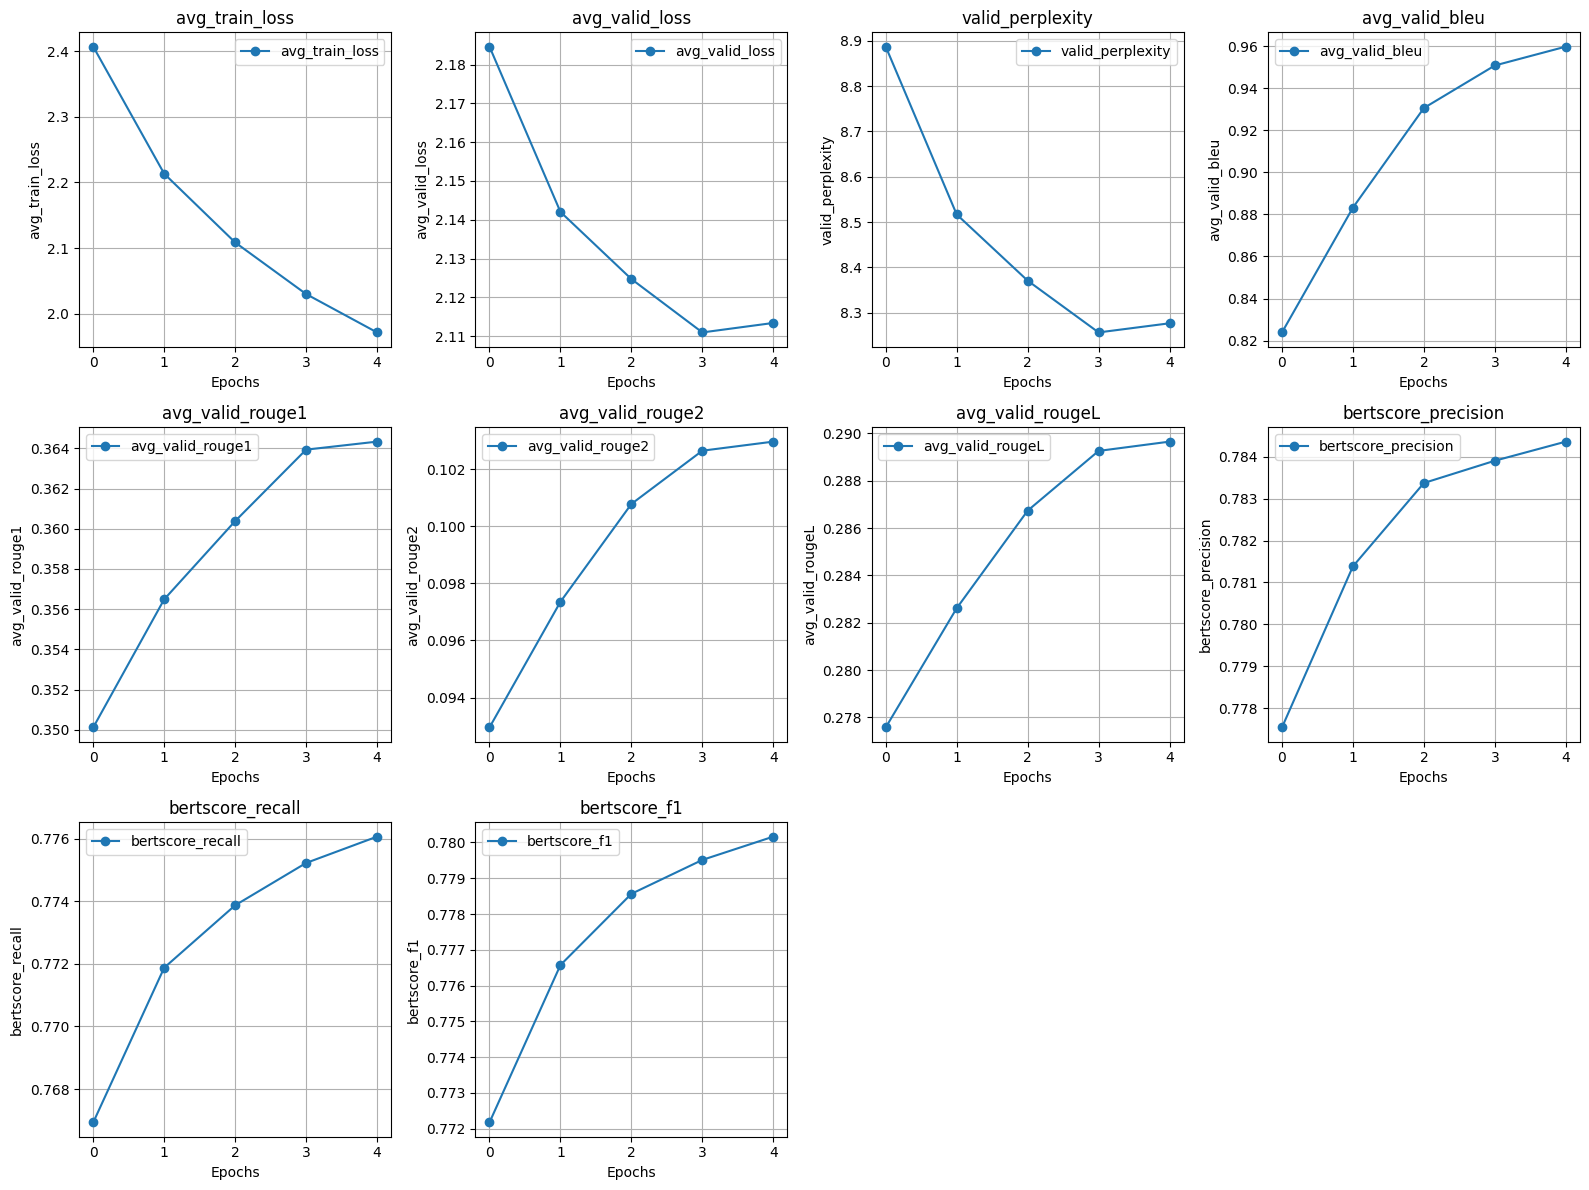

In [ ]:
import matplotlib.pyplot as plt

# 서브플롯 수 설정 (한 줄에 2개씩 배치)
num_metrics = len(history_df.columns)
ncols = 4
nrows = (num_metrics + ncols - 1) // ncols  # 필요한 행의 수 계산
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))

# axes를 1차원 배열로 변환 (서브플롯이 여러 줄일 경우)
axes = axes.flatten()

# 각 메트릭을 서브플롯에 그리기
for ax, (metric_name, metric_values) in zip(axes, history_df.items()):
    ax.plot(history_df.index, metric_values, marker='o', label=metric_name)
    ax.set_title(metric_name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)
    ax.grid(True)
    ax.legend()

# 남은 빈 서브플롯 숨기기
for ax in axes[len(history_df.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()